In [58]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import datetime

plt.rcParams["figure.figsize"] = (20, 5)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [59]:
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + timestamp
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
version_dir = "version/" + timestamp 

os.makedirs(version_dir)

In [60]:
pattern_length = 4

dataset = pd.read_csv("data/SEG_dataset_{}.csv".format(pattern_length))
dataset.head()

,delta,t,t+1
0,-1587653544,95444983808,93857330264
1,6172925864,87674650304,93847576168
2,-6187909720,93857313352,87669403632
3,-6187918552,93857325056,87669406504
4,-6198466584,93857330264,87658863680


In [61]:
from sklearn.model_selection import train_test_split

train_val_set, test_set = train_test_split(dataset, test_size=0.4, shuffle=False, random_state=42)

In [62]:
data_counts = pd.Series(data=train_val_set["delta"]).value_counts()
data_counts

 16384         1380
 8192           574
 20480          527
 4096           387
 12288          302
               ... 
-95445424         1
-15198400         1
-53490108         1
 6263810353       1
-6318048          1
Name: delta, Length: 63732, dtype: int64

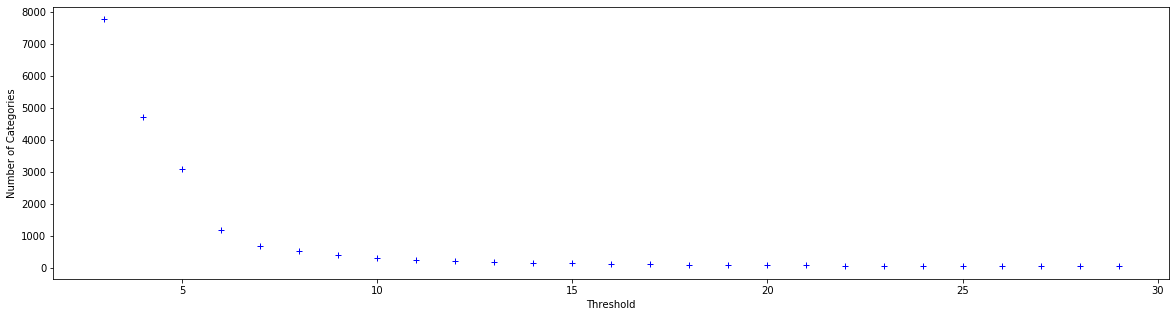

In [7]:
data_over_threshold_incremental = pd.DataFrame(data=[(data_counts > i).value_counts().values for i in range(3, 30)], columns=["Under Threshold", "Over Threshold"])
plt.plot([i for i in range(3, 30)], data_over_threshold_incremental["Over Threshold"], "b+")
plt.xlabel("Threshold")
plt.ylabel("Number of Categories")
plt.show()

In [27]:
(data_counts > 5).value_counts().values # Categories under / over Threshold

array([60645,  3087], dtype=int64)

In [48]:
over_threshold = (data_counts > 5)
over_threshold_index = over_threshold.index[over_threshold == True]
data_counts[over_threshold]

 16384        1380
 8192          574
 20480         527
 4096          387
 12288         302
              ... 
-172936          6
 14504           6
-480572064       6
-63405824        6
 21216           6
Name: delta, Length: 3087, dtype: int64

In [51]:
# Points in Categories, Points not in Categories, Total Dataset size
data_counts[over_threshold].sum(), len(train_val_set["delta"]) - data_counts[over_threshold].sum(), len(train_val_set["delta"])

(28155, 94666, 122821)

In [57]:
(train_val_set["delta"].to_numpy() / 8).astype(np.int64)

array([-198456693,  771615733, -773488715, ...,       8192,   -2084128,
             -736], dtype=int64)

In [14]:
train_set, val_set = train_test_split(train_val_set, test_size=0.4, shuffle=False, random_state=42)

In [15]:
vocab_size = (data_counts > 5).value_counts().values[1] # 3087
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '-1'

In [23]:
delta_string = [str(d) for d in train_set["delta"].values.tolist()]
delta_string[:10]

['-1587653544',
 '6172925864',
 '-6187909720',
 '-6187918552',
 '-6198466584',
 '-6188717384',
 '10445192',
 '7775833344',
 '2784',
 '-11926336']

In [24]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok, lower=False)
tokenizer.fit_on_texts(delta_string)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'-1': 1,
 '16384': 2,
 '8192': 3,
 '20480': 4,
 '4096': 5,
 '12288': 6,
 '0': 7,
 '24576': 8,
 '32768': 9,
 '15840': 10}